# NYC Taxi Traffic Analysis

[NYC Taxi Traffic Analysis](https://www.kaggle.com/code/julienjta/nyc-taxi-traffic-analysis)

In [1]:
!pip3 install adtk

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 60 kB 10.6 MB/s            


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import adtk

In [4]:
from adtk.data import validate_series

df = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv",usecols=["timestamp","value"], index_col="timestamp", parse_dates=True,squeeze=True)
df = pd.DataFrame(df)
df.index = pd.to_datetime(df.index)
ts = validate_series(df)
ts.rename(columns = {"value":"Traffic"},inplace = True)
ts.index.rename("Time",inplace = True)

In [5]:
ts

,Traffic
Time,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [6]:
ts_train = ts.loc[ts.index<pd.to_datetime("2015-01-01 00:00:00")]
ts_test = ts.loc[ts.index>=pd.to_datetime("2015-01-01 00:00:00")]

[<AxesSubplot:>]

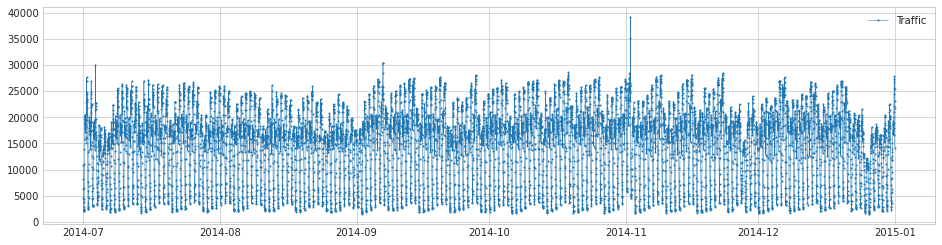

In [7]:
from adtk.visualization import plot
plot(ts_train)

In [8]:
frequencies={
    "hourly":2, # because two units in one hour
    "dayly":2*24,
    "weekly":2*24*7,
    "monthly":2*24*30}

In [9]:
from adtk.transformer import ClassicSeasonalDecomposition

s_transformed_by_frequency = ts_train

for key,frequence in frequencies.items():
    s_transformed = ClassicSeasonalDecomposition(freq=frequence).fit_transform(ts_train).rename(columns={"Traffic": "Seasonal decomposition residual for a "+key+"-frequency"})
    sum_residuals = abs(s_transformed).sum()
    
    print("A seasonal decomposition residual for a "+key+"-frequency gives a total of "+str(sum_residuals[0])+" of residuals.")
    
    s_transformed_by_frequency = pd.concat([s_transformed_by_frequency, s_transformed], axis=1)

A seasonal decomposition residual for a hourly-frequency gives a total of 49532483.13586956 of residuals.
A seasonal decomposition residual for a dayly-frequency gives a total of 25077604.68478261 of residuals.
A seasonal decomposition residual for a weekly-frequency gives a total of 11356163.962962965 of residuals.
A seasonal decomposition residual for a monthly-frequency gives a total of 23972160.476190474 of residuals.


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

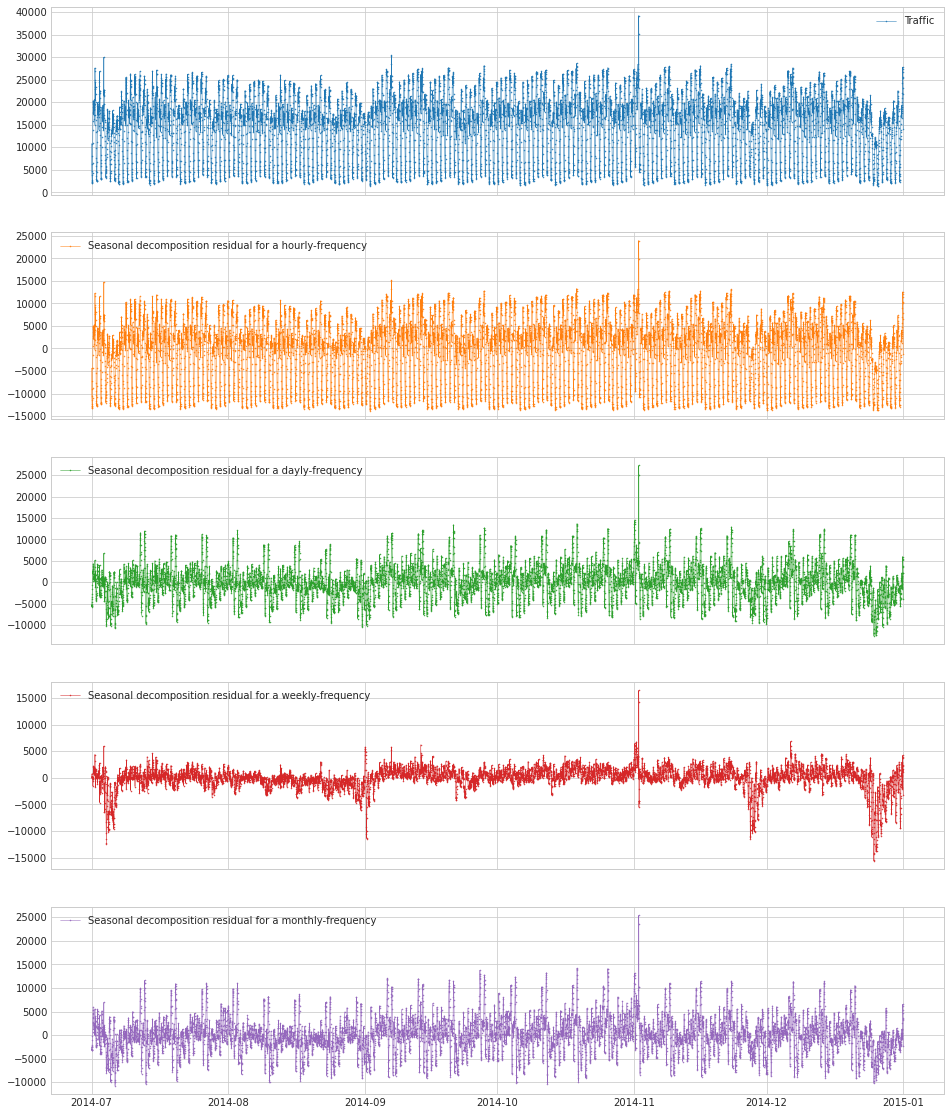

In [10]:
plot(s_transformed_by_frequency, ts_markersize=1)

[<AxesSubplot:>]

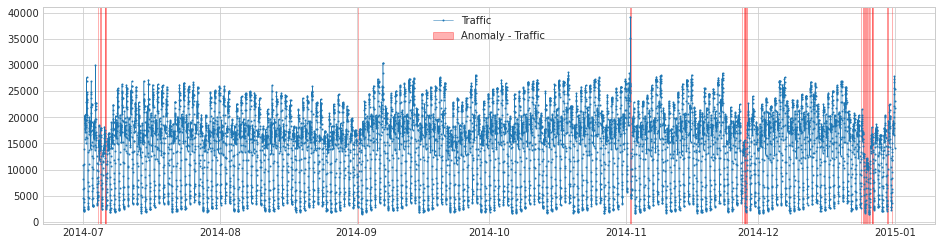

In [11]:
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD(c=5.0, side="both")
anomalies = seasonal_ad.fit_detect(ts_train)
plot(ts_train, anomaly=anomalies, anomaly_color="red")

In [12]:
from adtk.data import to_events
anomalies_events = to_events(anomalies)["Traffic"]
nb_anomalies = len(anomalies_events)
print(str(nb_anomalies)+" anomalies have been detected.")

19 anomalies have been detected.


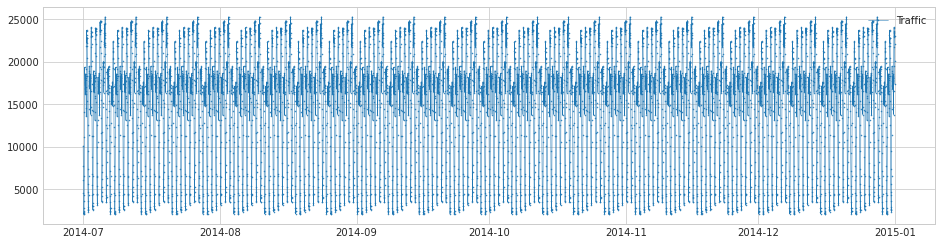

In [13]:
residuals = ClassicSeasonalDecomposition().fit_transform(ts_train)
pattern = ts_train - residuals
plot(pattern, ts_markersize=1);

In [14]:
def deviation(ts, residuals, event):
    pattern = ts - residuals
    subset_pattern = pattern.loc[(pattern.index>=event[0])&(pattern.index<=event[1])]
    sum_pattern = subset_pattern.sum()
    
    subset_residuals = residuals.loc[(residuals.index>=event[0])&(residuals.index<=event[1])]
    sum_residuals = subset_residuals.sum()
    
    return int(round(sum_residuals/sum_pattern*100))

In [15]:
deviation_ = deviation(ts_train, residuals, anomalies_events[0])
print("For the first anomaly, we have a deviation of "+str(deviation_)+"%.")

For the first anomaly, we have a deviation of -64%.


In [16]:
def normal_traffic(ts, residuals, event):
    pattern = ts - residuals
    subset_pattern = pattern.loc[(pattern.index>=event[0])&(pattern.index<=event[1])]
    
    return int(round(subset_pattern.mean()))

In [17]:
normal_traffic_ = normal_traffic(ts_train, residuals, anomalies_events[0])
print("For the first anomaly, we have a normal traffic of "+str(normal_traffic_)+" taxis.")

For the first anomaly, we have a normal traffic of 17366 taxis.


In [18]:
def duration(event):
    delta = event[1] - event[0]
    
    return str(delta)

In [19]:
duration_ = duration(anomalies_events[0])
print("For the first anomaly, we have a duration of "+duration_+".")

For the first anomaly, we have a duration of 0 days 02:29:59.999999999.


In [20]:
def frequency(ts, anomalies):
    delta = ts.index.max() - ts.index.min()
    return round(len(anomalies)/delta.days*30,2)

In [21]:
frequency_ = frequency(ts_train, anomalies_events)
print("There are  "+str(frequency_)+" anomalies a month.")

There are  3.11 anomalies a month.


In [22]:
recap_anomalies = pd.DataFrame(columns=['Start', 'End', 'Duration', 'Deviation', 'Normal Traffic', 'Way'])

for event in anomalies_events:
    deviation_ = deviation(ts_train, residuals, event)
    normal_traffic_ = normal_traffic(ts_train, residuals, event)
    duration_ = duration(event)
    
    way = 'UP' if deviation_>0 else 'DOWN'
    
    data = {'Start': [str(event[0])],
        'End': [str(event[1])],
        'Duration': [duration_],
        'Deviation': [deviation_],
        'Normal Traffic': [normal_traffic_],
        'Way': [way]}
    
    new_row = pd.DataFrame(data)
    recap_anomalies = pd.concat([recap_anomalies, new_row],ignore_index=True)
    
frequency_ = frequency(ts_train, anomalies_events)
print("There are in average "+str(frequency_)+" anomalies a month.")

There are in average 3.11 anomalies a month.


In [23]:
recap_anomalies

,Start,End,Duration,Deviation,Normal Traffic,Way
0,2014-07-04 07:30:00,2014-07-04 09:59:59.999999999,0 days 02:29:59.999999999,-64,17366,DOWN
1,2014-07-04 19:00:00,2014-07-04 22:29:59.999999999,0 days 03:29:59.999999999,-40,24037,DOWN
2,2014-07-05 23:00:00,2014-07-05 23:29:59.999999999,0 days 00:29:59.999999999,-35,25053,DOWN
3,2014-07-06 00:00:00,2014-07-06 01:59:59.999999999,0 days 01:59:59.999999999,-40,22910,DOWN
4,2014-09-01 07:00:00,2014-09-01 09:29:59.999999999,0 days 02:29:59.999999999,-67,15731,DOWN
5,2014-11-02 01:00:00,2014-11-02 01:59:59.999999999,0 days 00:59:59.999999999,70,21827,UP
6,2014-11-27 07:30:00,2014-11-27 09:59:59.999999999,0 days 02:29:59.999999999,-57,18210,DOWN
7,2014-11-27 18:30:00,2014-11-27 21:59:59.999999999,0 days 03:29:59.999999999,-39,23622,DOWN
8,2014-11-27 22:30:00,2014-11-28 00:29:59.999999999,0 days 01:59:59.999999999,-43,21027,DOWN
9,2014-11-28 07:30:00,2014-11-28 08:59:59.999999999,0 days 01:29:59.999999999,-57,17318,DOWN


[<AxesSubplot:>]

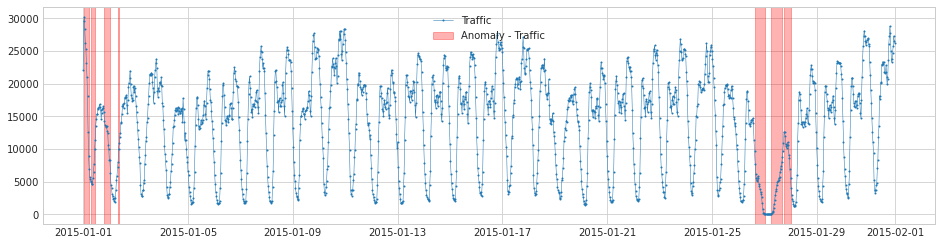

In [24]:
anomalies_test = seasonal_ad.predict(ts_test)
anomalies_events_test = to_events(anomalies_test)["Traffic"]
plot(ts_test, anomaly=anomalies_test, anomaly_color="red")